In [61]:
import os
from os import listdir
from os.path import join, isfile
import re
import pdfplumber
import spacy
import json
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet
from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(20,12)})

data_path = os.path.join("D:/", "data", "drmkc", "pdfs", "drmkc.jrc.ec.europa.eu")
work_path = os.path.join("D:/", "data", "drmkc", "work")
filenames = [join(data_path,f) for f in listdir(data_path) if isfile(join(data_path, f))]
filenames = [filename for filename in filenames if filename.endswith('.pdf')]

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 2500000

mallet_path = os.path.join('C:\\', 'mallet', 'mallet-2.0.8', 'bin', 'mallet.bat') # update this path

In [6]:
data = []

In [7]:
problem_files = []

for c, filename in enumerate(filenames, start = 1):
    
    if filename in [entry.get('filename') for entry in data]:
        continue
    
    progress = "|{0}| {1:.2f} %".format(("="*int(c/len(filenames) * 50)).ljust(50), c/len(filenames) * 100)
    
    entry = {}
    entry['filename'] = filename
    
    try:
        with pdfplumber.open(join(data_path, filename)) as pdf:
            try:
                pdf_text = '\n'.join([page.extract_text() for page in pdf.pages if page.extract_text() is not None])
                entry['text'] = pdf_text
            except Exception as e:
                print(filename)
                raise e
    except:
        problem_files.append(filename)
    
    data.append(entry)
    
    print(progress, end = "\r")

In [8]:
len(data)

127

In [9]:
data = [entry for entry in data if 'text' in entry]

In [10]:
len(data)

125

## Keyword analysis

In [20]:
# Tokenizer

stop_words = list(nlp.Defaults.stop_words)
                                            
def tokenizer_custom(text, stop_words=stop_words, tags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    text = text.replace('\n', ' ')
    numbers_re = r".*\d.*"
    punct_regex = r"[^\w\s]"
    
    doc = nlp(text)
        
    pos_tags = tags # Keeps proper nouns, adjectives and nouns
    
    exceptions = []
    
    tokens = []
      
    for word in doc:
        if ((word.pos_ in pos_tags) or (any([exception in word.text for exception in exceptions]))) and (len(word.lemma_) > 4) and (word.lemma_.lower() not in stop_words) and not (re.match(numbers_re, word.lemma_.lower())):
            token = word.lemma_.lower() # Returning the word in lower-case.
            token = re.sub(punct_regex, "", token)
            tokens.append(token)

    return(tokens)


# TF-IDF

def create_tfidfdtm(df, tokensvar = 'tokens'):

    def return_tokens(tokens):
        return tokens

    text_tokens = df['tokens']

    vectorizer = TfidfVectorizer(
        tokenizer=return_tokens,
        preprocessor=return_tokens,
        token_pattern=None,
        min_df = 5,
        max_df = 0.9
        )

    transformed_documents = vectorizer.fit_transform(text_tokens)

    transformed_documents_as_array = transformed_documents.toarray()
    tfidf_dtm = pd.DataFrame(transformed_documents_as_array, columns = vectorizer.get_feature_names())
    
    return(tfidf_dtm)

In [12]:
pos_tags = ['NOUN', 'ADJ', 'PROPN']

for c, entry in enumerate(data, start = 1):
    entry['tokens'] = tokenizer_custom(entry.get('text'), tags = pos_tags)
    
    progress = "|{0}| {1:.2f} %".format(("="*int(c/len(data) * 50)).ljust(50), c/len(data) * 100)
    print(progress, end = "\r")

In [13]:
outname = "drmkc-pdfs_tokenized.json"

with open(os.path.join(work_path, outname), 'w', encoding = 'utf-8') as f:
    json.dump(data, f)

In [31]:
df = pd.DataFrame.from_records(data)
df['text_id'] = pd.Series(df.index).apply(lambda i: "text_" + str(i))

In [32]:
df_long = df.explode('tokens').rename(columns = {'tokens': 'token'})

In [33]:
df_long['token'].value_counts()[0:15]

disaster      7570
hazard        5460
assessment    4706
european      4310
management    4133
climate       3868
flood         3795
change        3620
system        3480
impact        3278
natural       3205
level         2977
research      2908
journal       2906
event         2805
Name: token, dtype: int64

In [26]:
tfidf = create_tfidfdtm(df)

tfidf_tidy = tfidf.melt(var_name='token', value_name = 'tf-idf', ignore_index = False)
tfidf_tidy['text_id'] = pd.Series(tfidf_tidy.index).apply(lambda i: "text_" + str(i))

In [39]:
df_long_unique = df_long.drop_duplicates(subset = ['filename', 'token'])

df_tfidf = pd.merge(df_long_unique, tfidf_tidy, how = "left", on = ["text_id", "token"])

df_tfidf = pd.merge(df_tfidf, df.loc[:, 'tokens'], how = "left", left_index = True, right_index = True)

In [41]:
df_tfidf.head()

,filename,text,token,text_id,tf-idf,tokens
0,D:/data\drmkc\pdfs\drmkc.jrc.ec.europa.eu\ec--...,\n \n \n \n \n \nFlood damage survey after ma...,flood,text_0,0.475326,"[flood, damage, survey, major, flood, norway, ..."
1,D:/data\drmkc\pdfs\drmkc.jrc.ec.europa.eu\ec--...,\n \n \n \n \n \nFlood damage survey after ma...,damage,text_0,0.379561,"[fifth, technical, workshop, approach, damage,..."
2,D:/data\drmkc\pdfs\drmkc.jrc.ec.europa.eu\ec--...,\n \n \n \n \n \nFlood damage survey after ma...,survey,text_0,0.136319,"[european, commission, brussels, final, commis..."
3,D:/data\drmkc\pdfs\drmkc.jrc.ec.europa.eu\ec--...,\n \n \n \n \n \nFlood damage survey after ma...,major,text_0,0.047615,"[european, commission, brussels, final, commis..."
4,D:/data\drmkc\pdfs\drmkc.jrc.ec.europa.eu\ec--...,\n \n \n \n \n \nFlood damage survey after ma...,norway,text_0,0.272853,"[inform, index, methodology, result, poljanšek..."


In [46]:
df_tfidf.groupby('token')['tf-idf'].mean().sort_values(ascending = False)[0:50]

token
gdacs            0.233951
cascais          0.183807
inform           0.154161
interviewer      0.148301
florence         0.146865
interview        0.139257
disaster         0.138575
journal          0.129900
stakeholders     0.124228
lunch            0.115440
garden           0.115329
natech           0.115279
hazard           0.113603
climate          0.112572
activities       0.109901
drought          0.107719
covenant         0.104495
flood            0.103372
                 0.100763
click            0.100499
hp               0.095204
personal         0.093373
alarm            0.089924
assessment       0.089092
european         0.086322
april            0.084621
graphic          0.081067
peril            0.079656
regret           0.079199
surminski        0.078691
sparks           0.078254
change           0.077848
desinventar      0.076916
authors          0.075976
management       0.075072
safety           0.074929
datum            0.074211
accident         0.073240
natura

## Word2Vec

In [51]:
all_sentences = []

for entry in data:
    sentences = entry.get('text').split("\n")
    all_sentences = all_sentences + sentences

sentence_tokens = []

for sentence in all_sentences:
    tokens = tokenizer_custom(sentence)
    sentence_tokens.append(tokens)
    
print(len(sentence_tokens))

In [53]:
model = Word2Vec(sentences=sentence_tokens, window=5, min_count=100, workers=4)

In [59]:
model.wv.most_similar('earthquake')

[('trigger', 0.7434147596359253),
 ('seismic', 0.6870116591453552),
 ('industrial', 0.6807842254638672),
 ('landslide', 0.6502715349197388),
 ('geophysical', 0.642982006072998),
 ('collapse', 0.6396244764328003),
 ('flash', 0.6273693442344666),
 ('multiple', 0.6260375380516052),
 ('installation', 0.6246126294136047),
 ('frequent', 0.6229647994041443)]

In [68]:
# https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model.wv.__getitem__(w) for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

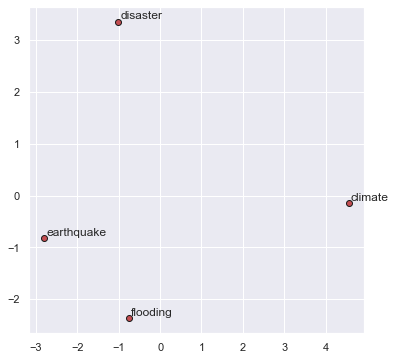

In [69]:
display_pca_scatterplot(model = model, words = ['climate', 'disaster', 'flooding', 'earthquake'])

In [67]:
model.wv.__getitem__('climate')

array([ 0.47197855, -0.22610386,  0.12468266, -0.11042812,  0.08864352,
       -0.682457  , -0.62890935, -0.03651674,  0.12019701,  0.5866998 ,
        0.29930466, -0.11338794,  0.640254  , -0.34219185,  0.78748894,
        1.0230747 ,  0.21799916,  0.14618126,  0.7312597 , -0.9240628 ,
       -1.3315586 ,  0.68454623, -0.7056176 ,  0.34107652,  0.330009  ,
       -0.42169073, -0.4077712 ,  0.427205  , -0.26099563,  0.21202241,
       -0.19059819,  0.08945513,  0.43145093,  0.19888516, -0.2777784 ,
       -0.46523273, -0.02421776, -0.28987938, -1.0342307 , -0.86499166,
       -0.5399945 ,  0.798581  , -0.77354527,  0.4197254 ,  0.33842027,
       -0.37107962,  0.54595447,  0.9473916 ,  0.74748546, -0.81370944,
        0.98479897, -0.06068896, -0.12833127,  0.34784728, -0.29855523,
        0.668138  , -0.30409333,  0.26043788, -0.594141  ,  0.3514604 ,
       -0.69111484,  0.63024527,  1.0151523 ,  0.2902618 ,  1.1976529 ,
        1.1316167 , -0.14451939, -0.6066962 , -1.3420815 , -0.40

## Topic model

In [ ]:
tokens_list = [entry.get('tokens') for entry in data]

# Create Dictionary
id2word = corpora.Dictionary(tokens_list) # integer id per word

# Term Document Frequency
corpus = [id2word.doc2bow(tokens) for tokens in tokens_list] # bag-of-word(bow) tuple for each text - id, count

# View
print(corpus[:1])

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
lda_model = LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)

In [ ]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score - https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf
coherence_model_lda = CoherenceModel(model=lda_model, texts=comments_tokens, dictionary=id2word, coherence='c_v')
coherence_ldamodel = coherence_model_lda.get_coherence() 
print('\nCoherence Score: ', coherence_ldamodel)

In [ ]:
pprint(lda_model.print_topics(num_words=10))

In [ ]:
# Function for getting dominant topic for one corpus entry (bag-of-word tuple - bowt)
def get_dominant_topic(corpus_bowt, ldamodel = lda_model):
    
    dominant_topic_dict = dict()
    
    topics_doc = ldamodel[corpus_bowt]
    
    dominant_topic = sorted(topics_doc, key = lambda t: t[1], reverse = True)[0]
    topic_num = dominant_topic[0]
    topic_prob = dominant_topic[1]
    
    topic_kws = [word for word, prop in ldamodel.show_topic(topic_num)]
    
    dominant_topic_dict['dominant_topic'] = topic_num
    dominant_topic_dict['topic_probability'] = topic_prob
    dominant_topic_dict['topic_keywords'] = topic_kws
    
    return(dominant_topic_dict) # Note that domninant topic info is returned as dictionary

# Creating list of dictionaries - one dictionary contatining dominant topic info for each corpus entry
corpus_dominant_topics = list()
for bowt in corpus:
    dominant_topic = get_dominant_topic(bowt)
    corpus_dominant_topics.append(dominant_topic)

**Workflow**

- [x] Read in pdfs
- [x] tokenize
- [ ] filter keywords
- [ ] keyword analysis
- [ ] topic model (see reddit-miner example)